In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
np.random.seed(10)
random.seed(10)


## Functions for loading data

In [21]:
def load_training_and_validataion_dataset(path_to_partitions,train_splits):
    import random
    ## Training
    # training_partions = random.sample(range(10),train_splits)
    training_partions = [9, 0, 6, 3, 4, 8, 1, 7]

    ## Validation
    validation_partions = [i for i in range(10) if i not in training_partions]
    partitions = []
    for file in os.listdir(path_to_partitions):
        path_to_file = os.path.join(path_to_partitions,file)
        data = pd.read_csv(path_to_file,sep="\t",names=["peptide","label","HLA_allele"])
        partitions.append(data)
    training_df = pd.concat([partitions[i] for i in training_partions])
    validation_df = pd.concat([partitions[i] for i in validation_partions])
    return training_df, validation_df,training_partions,validation_partions

def retrieve_information_from_df(data_split,entire_df):
    immunogenicity = []
    response = []
    tested_subjects = []
    positive_subjects = []
    binding_scores = []
    for i,row in data_split.iterrows():
        peptide, HLA = row["peptide"], row['HLA_allele']
        original_entry = entire_df[(entire_df['peptide']==peptide) & (entire_df['HLA'] == HLA)]
        assert len(original_entry) == 1
        immunogenicity.append(float(original_entry['immunogenicity']))
        response.append(original_entry['Response'].values[0])
        tested_subjects.append(int(original_entry['tested_subjects']))
        positive_subjects.append(int(original_entry['positive_subjects']))
        binding_scores.append(float(original_entry['binding_score']))
    data_split['immunogenicity'] = immunogenicity
    data_split['response'] = response
    data_split['test'] = tested_subjects
    data_split['positive_subjects'] = positive_subjects
    data_split['binding_score'] = binding_scores
    return data_split  


def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        binding_score = row['binding_score']


        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Loading the data

In [22]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

# Load dataset
# entire_df = pd.read_csv('../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_IFNg_assay.csv')
entire_df = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding.csv")
# entire_df = pd.read_csv('../data/deep_immuno_2.csv')


# Allocating the partitions of the trainign and validation data
training_df, validation_df, training_partions,validation_partions = load_training_and_validataion_dataset(path_to_partitions="../data/multi_assay_parts",train_splits=8)


# Creating the training dataframe (With correct information such as tested and positive subjects aswell as label)
training_df_entire = retrieve_information_from_df(training_df,entire_df)
# Shuffling the dataframe
training_df_entire = training_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)

# Creating the validation dataframe (With correct information such as tested and positive subjects aswell as label)
validation_df_entire = retrieve_information_from_df(validation_df,entire_df)
# Shuffling the dataframe
validation_df_entire = validation_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)

print("##Encoding Training data")
train_peptides_encoded,train_HLA_encoded,train_binding_scores_encoded,train_label_encoded = encode_dataset(training_df_entire,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
print("##Encoding Validation data")
val_peptides_encoded,val_HLA_encoded,val_binding_scores_encoded ,val_label_encoded = encode_dataset(validation_df_entire,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

peptide_train = train_peptides_encoded.reshape(-1,1,10,12)
HLA_train = train_HLA_encoded.reshape(-1,1,34,12)
binding_train = train_binding_scores_encoded
label_train = train_label_encoded

peptide_val = val_peptides_encoded.reshape(-1,1,10,12)
HLA_val = val_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
binding_val = val_binding_scores_encoded
label_val = val_label_encoded


##Encoding Training data
##Encoding Validation data


## Definning the model

In [23]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

In [24]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

33

In [25]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
          

In [26]:
# hyperameters of the model
peptide_input_channels = peptide_train.shape[1]
peptide_input_height = peptide_train.shape[2]
peptide_input_width = peptide_train.shape[3]

hla_input_channels = HLA_train.shape[1]
hla_input_height = HLA_train.shape[2]
hla_input_width = HLA_train.shape[3]

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(15,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_HLA = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Denselayer
        self.L_in = Linear(in_features=161, # 161 if bingding score
                            out_features=128)

        self.drop_out = nn.Dropout(p=0.2)
        self.L_out = Linear(in_features=128,
                            out_features=2,
                            bias=False)


    def forward(self, peptide, HLA, binding_score=None): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        peptide = self.conv1_peptide(peptide)
        peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        HLA = self.conv1_HLA(HLA)
        HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        # Combining the output
        if binding_score is None:
            combined_input = torch.cat((peptide, HLA), 1)
        else:
            combined_input = torch.cat((peptide, HLA,binding_score), 1)
        x = self.L_in(combined_input)
        x = self.drop_out(x)
        x = relu(x)
    
        x = self.L_out(x)
        x = nn.ReLU()(x)
        return softmax(x, dim=1)

net = Net()
net.apply(initialize_weights)
print(net)

Net(
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(15, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2_HLA): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1))
  (BatchNorm_conv2_HLA): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool2_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation

Testing flow through network

In [27]:
peptide_random = np.random.normal(0,1, (10, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 1, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random,binding_random)
output

tensor([[0.8412, 0.1588],
        [0.8503, 0.1497],
        [0.7638, 0.2362],
        [0.6375, 0.3625],
        [0.9433, 0.0567],
        [0.5228, 0.4772],
        [0.9238, 0.0762],
        [0.9766, 0.0234],
        [0.5633, 0.4367],
        [0.7406, 0.2594]], grad_fn=<SoftmaxBackward0>)

## Creating testing and validataion datasets

In [28]:
batch_size = 100
peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))


peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))

## Training and evaluating the model

In [29]:
import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-4)

In [30]:
epochs = 100
train_accuracies = []
val_accuracies = []
losses = []
all_val_targets_pr_epoch = []
all_val_predictions_pr_epoch = []
all_val_probabilities_pr_epoch = []
for epoch in range(epochs):
    net.train()
    current_loss = 0
    for train_batch_index in range(len((peptide_train_loader))):
        train_peptides = peptide_train_loader[train_batch_index]
        train_HLA = HLA_train_loader[train_batch_index]
        train_labels = label_train_loader[train_batch_index].long().reshape(-1)
        train_binding_scores = binding_score_train_loader[train_batch_index].reshape(len(train_peptides),1)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = net(train_peptides,train_HLA,train_binding_scores)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

    # print(epoch, current_loss/batch_size)
    losses.append(current_loss/len((peptide_train_loader)))

    net.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long().reshape(-1)
            train_binding_scores = binding_score_train_loader[i].reshape(len(train_peptides),1)
            outputs = net(train_peptides,train_HLA,train_binding_scores)
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.numpy().tolist()
            all_train_targets += train_labels.numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        all_probabilities_val = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j]
            val_HLA = HLA_val_loader[j]
            val_labels = label_val_loader[j].long().reshape(-1)
            val_binding_scores = binding_score_val_loader[j].reshape(len(val_peptides),1)
            outputs = net(val_peptides,val_HLA,val_binding_scores)
            probability,predicted_labels =  torch.max(outputs, 1)
            all_predicted_val_labels += predicted_labels.numpy().tolist()
            all_val_targets += val_labels.numpy().tolist()
            all_probabilities_val += probability.numpy().tolist()

    # Calculating the accuracies
    train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
    val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
    # Saving the predicitons for further validation
    all_val_targets_pr_epoch.append(all_val_targets)
    all_val_predictions_pr_epoch.append(all_predicted_val_labels)
    all_val_probabilities_pr_epoch.append(all_probabilities_val)
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))
    


Epoch  1 : Train Loss 0.694351 , Train acc 0.573121, Valid acc 0.553714
Epoch 11 : Train Loss 0.574410 , Train acc 0.726019, Valid acc 0.686340
Epoch 21 : Train Loss 0.558119 , Train acc 0.748742, Valid acc 0.694297
Epoch 31 : Train Loss 0.547330 , Train acc 0.761240, Valid acc 0.695623
Epoch 41 : Train Loss 0.540621 , Train acc 0.772926, Valid acc 0.697613
Epoch 51 : Train Loss 0.534330 , Train acc 0.784288, Valid acc 0.704244
Epoch 61 : Train Loss 0.525284 , Train acc 0.791755, Valid acc 0.700928
Epoch 71 : Train Loss 0.519234 , Train acc 0.799546, Valid acc 0.702255
Epoch 81 : Train Loss 0.516253 , Train acc 0.812693, Valid acc 0.705570
Epoch 91 : Train Loss 0.505837 , Train acc 0.824541, Valid acc 0.708223


(Text(0.5, 0, 'epochs'), Text(0, 0.5, 'Acc'))

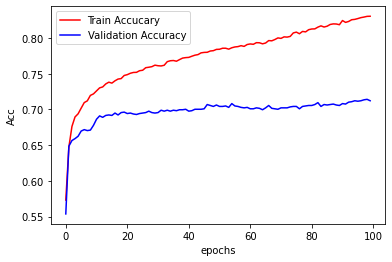

In [31]:
epoch = np.arange(len(train_accuracies))
plt.figure()
plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')

In [32]:
val_predictions = np.array(all_val_predictions_pr_epoch)
val_labels = np.array(all_val_targets_pr_epoch)
val_probabilities = np.array(all_val_probabilities_pr_epoch)

EPOCH: 98 Recall: 0.7317073170731707 accuracy: 0.7141909814323607 f1-score: 0.7256524506683641


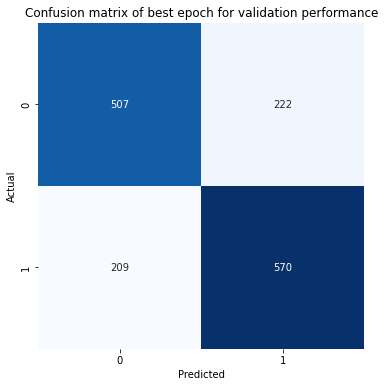

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score

best_epoch_model = np.argmax(val_accuracies)

# for epoch in range(len(val_predictions)):
fig = plt.figure(figsize=(10,6))
accuracy = accuracy_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])
recall = recall_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])
f1 = f1_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])

print(f"EPOCH: {best_epoch_model} Recall: {recall} accuracy: {accuracy} f1-score: {f1}")
plt.title("Confusion matrix of best epoch for validation performance")
conf_mat = confusion_matrix(val_labels[best_epoch_model],val_predictions[best_epoch_model])
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
labels_best_epoch = val_labels[best_epoch_model]
predictions_best_epoch = val_predictions[best_epoch_model]
probabilities_best_epoch = val_probabilities[best_epoch_model]
true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
dataframe = pd.DataFrame()
dataframe["Probs"] = probabilities_best_epoch
dataframe["Predictions"] = predictions_best_epoch
dataframe["Labels"] = labels_best_epoch
dataframe["True"] = true_predictions

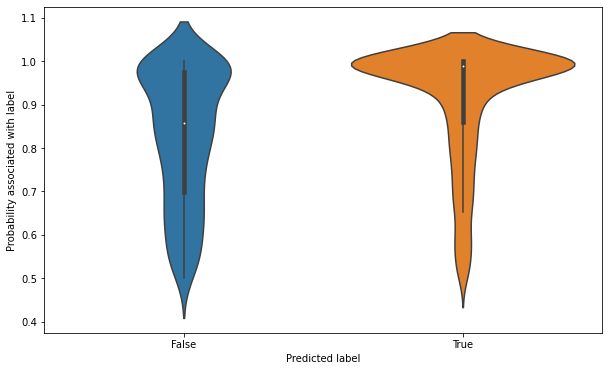

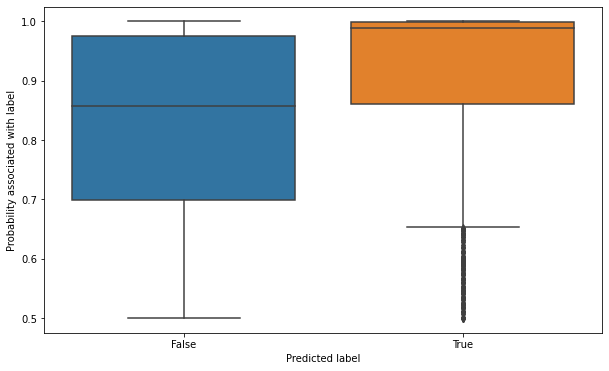

In [35]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(x="True", y="Probs", data=dataframe)
plt.xlabel("Predicted label")
plt.ylabel("Probability associated with label")
plt.show()

plt.figure(figsize=(10,6))
ax = sns.boxplot(x="True", y="Probs", data=dataframe)
plt.xlabel("Predicted label")
plt.ylabel("Probability associated with label")
plt.show()